# Generate 3D candidates

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM


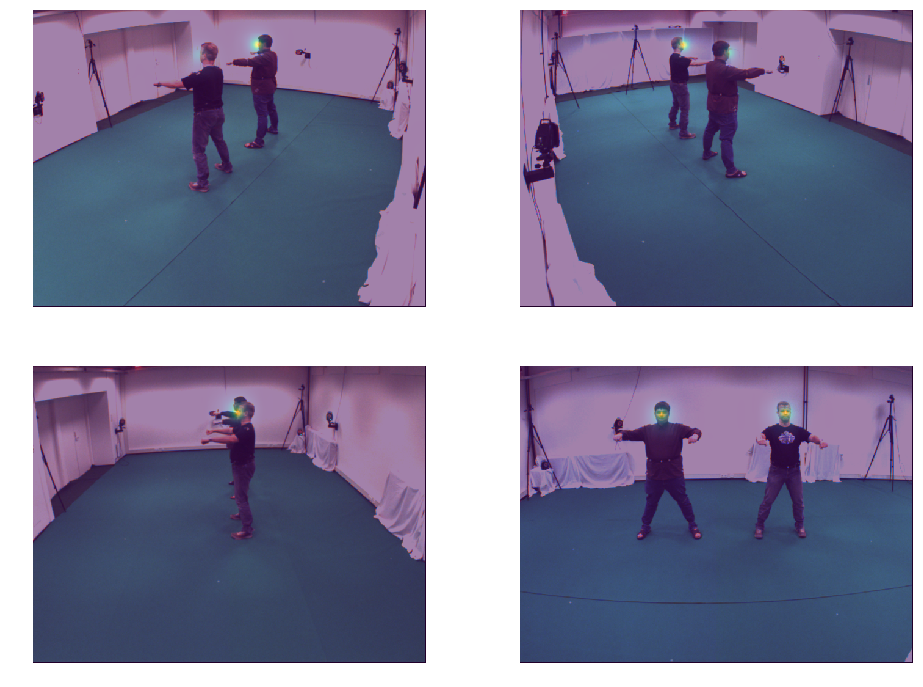

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.algorithm.heatmaps as mvhm
import mvpose.algorithm.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][0], X[1][0], X[2][0], X[3][0]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save('/tmp/heatmaps.npy', heatmaps)
        np.save('/tmp/pafs.npy', pafs)
        
Noses = [hm[:,:,0] for hm in heatmaps]

fig = plt.figure(figsize=(16,12))

for idx, (I, N) in enumerate(zip(Im, Noses)):
    ax = fig.add_subplot(2,2,idx+1)
    ax.imshow(I)
    ax.imshow(N, alpha=0.5)
    ax.axis('off')

plt.show()

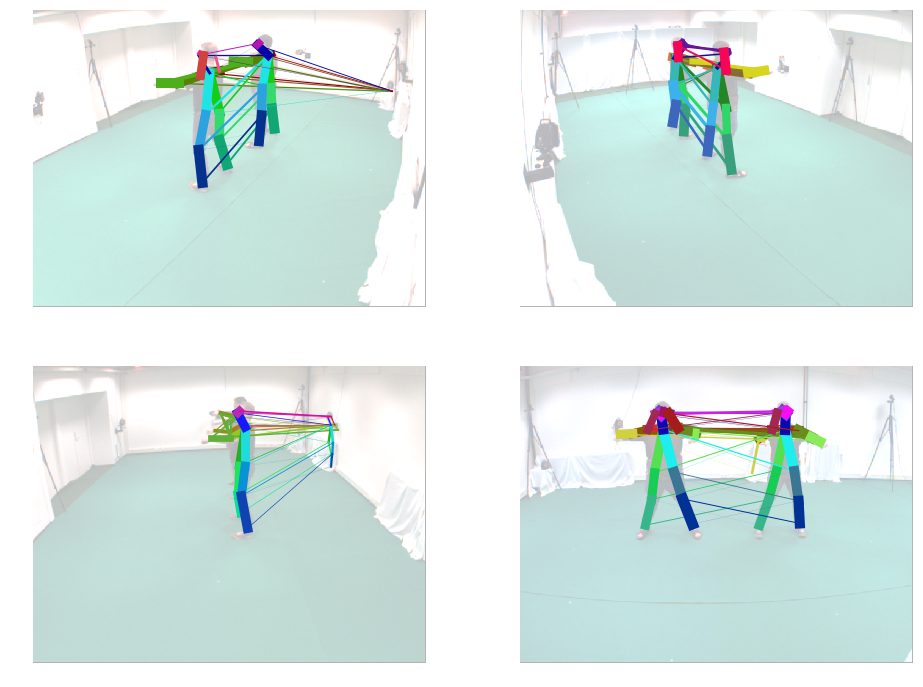

In [2]:
import mvpose.plot.limbs as pltlimbs

fig = plt.figure(figsize=(16,12))

Calib_undist = []
Peaks_undist = []
Peaks = []

for cid, cam in enumerate(Calib):
    hm = heatmaps[cid]
    paf = pafs[cid]
    peaks = mvhm.get_all_peaks(hm)
    Peaks.append(peaks)
    limbs = mvpafs.calculate_limb_weights(peaks, paf)
    ax = fig.add_subplot(2,2,cid+1)
    pltlimbs.plot(ax, Im[cid], peaks, limbs); ax.axis('off')
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    hm_ud, K_ud = gm.remove_distortion(hm, cam)     # TODO make this faster... this is not effiencent
    peaks_undist = mvhm.get_all_peaks(hm_ud)        # ...
    Peaks_undist.append(peaks_undist)
    
    Calib_undist.append({
        'K': K_ud,
        'distCoeff': 0,
        'rvec': rvec,
        'tvec': tvec
    })
    
plt.show()

Debugging, make sure that the peaks correspond to each other

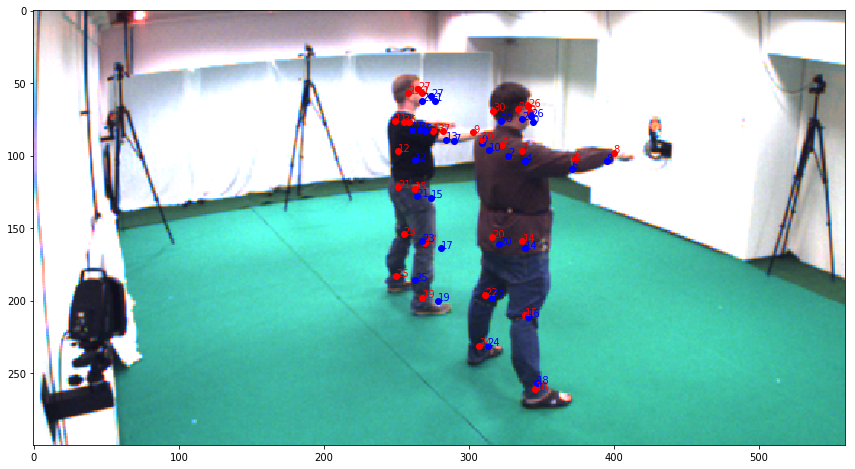

In [3]:
cam = 1
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(Im[cam][0:300,0:560])
# -----

peaks0 = Peaks[cam]; peaks_un0 = Peaks_undist[cam]

for idx, (p, p_un) in enumerate(zip(peaks0.get_all(), peaks_un0.get_all())):
    x0, y0, _ = p
    x1, y1, _ = p_un
    
    ax.scatter(x0, y0, color='red')
    ax.text(x0, y0, str(idx), color='red')
    ax.scatter(x1, y1, color='blue')
    ax.text(x1, y1, str(idx), color='blue')



plt.show()

elapsed: 0.0028066635131835938


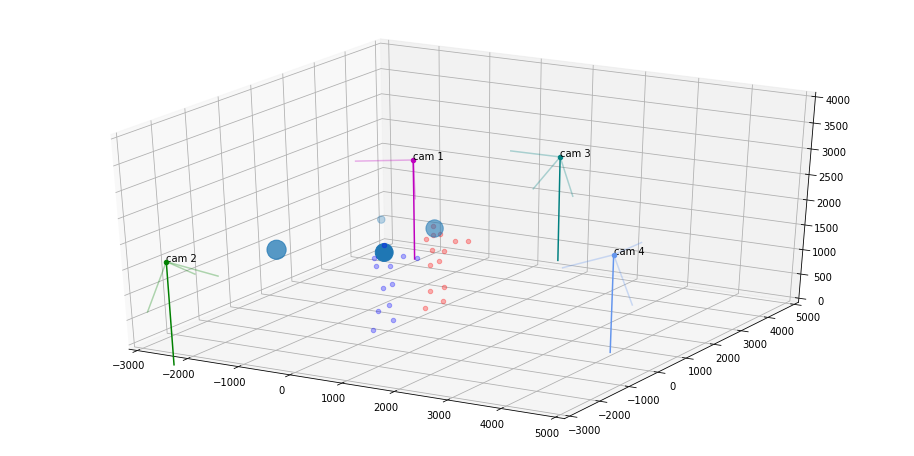

In [7]:
# ---------------------------
# import numpy as np
# import numpy.linalg as la
# import numpy.random as rnd
# import cv2
# from mvpose.geometry import geometry as gm
# from mvpose.algorithm.peaks import Peaks3D
# import mvpose.math as mvmath

# def triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2):
#     """
#         triangulate
#     :param peaks1: {Peaks}
#     :param K1:
#     :param rvec1:
#     :param tvec1:
#     :param peaks2: {Peaks}
#     :param K2:
#     :param rvec2:
#     :param tvec2:
#     :return:
#     """
#     assert peaks1.n_joints == peaks2.n_joints
#     n_joints = peaks1.n_joints

#     P1 = gm.get_projection_matrix_flat(K1, rvec1, tvec1)
#     P2 = gm.get_projection_matrix_flat(K2, rvec2, tvec2)

#     F = stereo.get_fundamental_matrix_flat(K1, rvec1, tvec1, 0,
#                                            K2, rvec2, tvec2, 0)

#     joints_3d = [None] * n_joints

#     for j in range(n_joints):
#         pts1 = peaks1[j]
#         pts2 = peaks2[j]

#         if len(pts1) > 0 and len(pts2) > 0:
#             epilines_1to2 = np.squeeze(
#                 cv2.computeCorrespondEpilines(pts1, 1, F))
#             if len(epilines_1to2.shape) <= 1:
#                 epilines_1to2 = np.expand_dims(epilines_1to2, axis=0)

#             epilines_2to1 = np.squeeze(
#                 cv2.computeCorrespondEpilines(pts2, 2, F))
#             if len(epilines_2to1.shape) <= 1:
#                 epilines_2to1 = np.expand_dims(epilines_2to1, axis=0)

#             # ----
#             # TODO this can be easily optimized with numba

#             W = []
#             Pt1 = []; Pt2 = []
#             for p1, (a1, b1, c1) in zip(pts1, epilines_1to2):
#                 for p2, (a2, b2, c2), in zip(pts2, epilines_2to1):
#                     w1 = 1/gm.line_to_point_distance(a1, b1, c1, p2[0], p2[1])
#                     w2 = 1/gm.line_to_point_distance(a2, b2, c2, p1[0], p1[1])
#                     w3 = p1[2] * p2[2]  # TODO play around with the formulas
#                     w = (min(1, w1) + min(1, w2) + w3)/3
#                     W.append(w)
#                     Pt1.append(p1[0:2])
#                     Pt2.append(p2[0:2])

#             Pt1 = np.transpose(np.array(Pt1))
#             Pt2 = np.transpose(np.array(Pt2))
#             W = np.array(W)
#             W = np.expand_dims(W, axis=1)


#             pts3d = np.transpose(
#                 cv2.triangulatePoints(P1, P2, Pt1, Pt2)
#             )
#             pts3d = gm.from_homogeneous(pts3d)

#             joints_3d[j] = np.concatenate([pts3d, W], axis=1)


#     return Peaks3D(joints_3d)




# -------------------------------------------

cam1 = 2; cam2 = 3

K1, rvec1, tvec1, _ = gm.get_camera_parameters(Calib_undist[cam1])
peaks1 = Peaks_undist[cam1]
K2, rvec2, tvec2, _ = gm.get_camera_parameters(Calib_undist[cam2])
peaks2 = Peaks_undist[cam2]

_start = time()
joints_3d = stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
#joints_3d = triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
_end = time()
print('elapsed:', _end - _start)

# ------------
# --- plot ---
# ------------

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])


cam_color = ['m', 'g', 'teal', 'cornflowerblue']
for i,cam in enumerate(Calib):
    R = cv2.Rodrigues(np.array(cam['rvec']))[0]
    t = np.array(cam['tvec'])
    P = -np.transpose(R) @ t
    x,y,z = P
    ax.scatter(x,y,z, color=cam_color[i])
    ax.text(x,y,z, 'cam ' + str(i+1))
    ax.plot([x,x], [y,y], [0,z], color=cam_color[i])
    
    M = np.transpose(R.copy())
    base = M[:,0]
    yaxis = M[:,1]
    lookat = M[:,2]
    f = 1000
    
    for e in [lookat,yaxis,base]:
        p2 = P + e * f
        ax.plot([P[0], p2[0]], [P[1], p2[1]], [P[2], p2[2]], color=cam_color[i], alpha=0.3)


color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)

# ------- plot ---------
for idx, point3d in enumerate(joints_3d):
    if not point3d is None:
        pts = point3d[:,0:3]
        w = point3d[:,3]
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1000*w)
    break

    
plt.show()

0 -> 1
0 -> 2
0 -> 3
1 -> 2
1 -> 3
2 -> 3


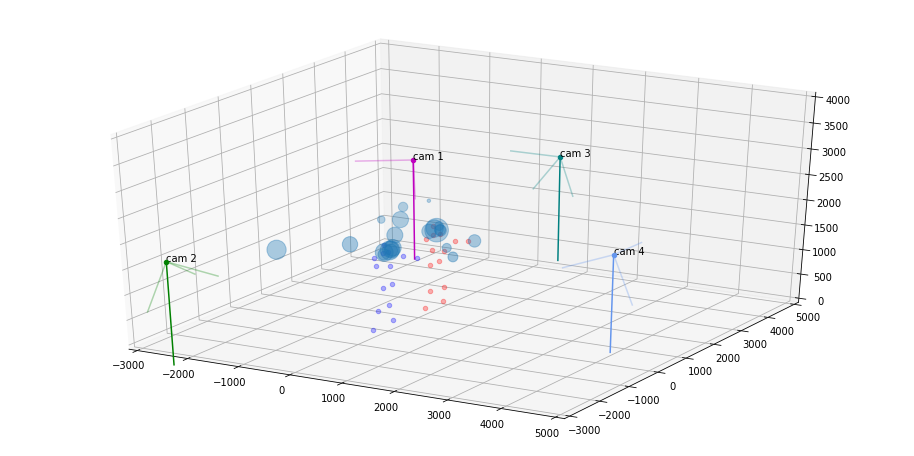

In [8]:
n_cameras = len(Calib)

all_peaks3d = None

for cam1 in range(n_cameras-1):
    K1, rvec1, tvec1, distCoef1 = \
        gm.get_camera_parameters(Calib_undist[cam1])
    assert distCoef1 == 0
    
    peaks1 = Peaks_undist[cam1]
    
    for cam2 in range(cam1+1, n_cameras):
        # ---------------------------------------
        print(str(cam1) + ' -> ' + str(cam2))
        # ---------------------------------------
        K2, rvec2, tvec2, distCoef2 = \
            gm.get_camera_parameters(Calib_undist[cam2])
        assert distCoef2 == 0
        
        peaks2 = Peaks_undist[cam2]
        
        if all_peaks3d is None:
            all_peaks3d = stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
        else:
            all_peaks3d.merge(
                stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2))

            
# =========================================
#              --- plot ---
# =========================================

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])


cam_color = ['m', 'g', 'teal', 'cornflowerblue']
for i,cam in enumerate(Calib):
    R = cv2.Rodrigues(np.array(cam['rvec']))[0]
    t = np.array(cam['tvec'])
    P = -np.transpose(R) @ t
    x,y,z = P
    ax.scatter(x,y,z, color=cam_color[i])
    ax.text(x,y,z, 'cam ' + str(i+1))
    ax.plot([x,x], [y,y], [0,z], color=cam_color[i])
    
    M = np.transpose(R.copy())
    base = M[:,0]
    yaxis = M[:,1]
    lookat = M[:,2]
    f = 1000
    
    for e in [lookat,yaxis,base]:
        p2 = P + e * f
        ax.plot([P[0], p2[0]], [P[1], p2[1]], [P[2], p2[2]], color=cam_color[i], alpha=0.3)


color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)], alpha=0.3)

# ------- plot ---------
for j in range(all_peaks3d.n_joints):
    point3d = all_peaks3d[j]
    if not point3d is None:
        pts = point3d[:,0:3]
        w = point3d[:,3]
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1000*w)
    break

plt.show()

In [6]:
max(w)

0.5564625081352405